In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import aligned_vae, vae
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy

In [2]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [3]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    return dist 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = scDataset(dim_reduction=False)
testset = testDataset()

# Similarity matrix
Note that for distance calculation, dimension reduction is necessary as raw data is too noisy
## Diffusion map distance

In [5]:
pca = PCA(n_components=30)

# atac_lsi = latent_semantic_indexing(atac, k = 30)
atac_pca = pca.fit_transform(atac)

rna_pca = pca.fit_transform(np.log1p(rna))

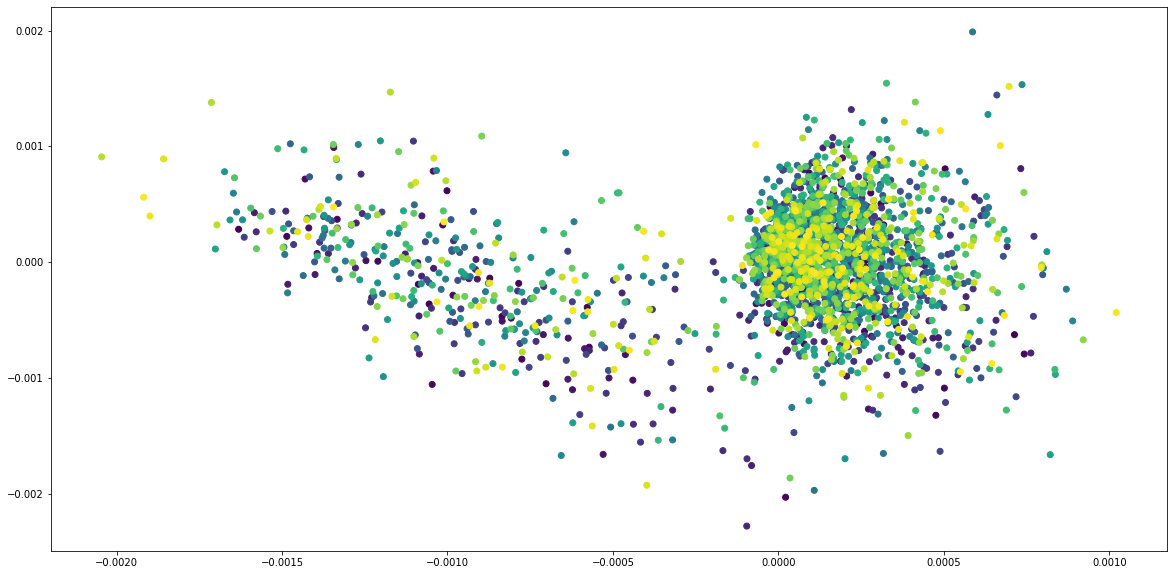

In [6]:
diffu_atac = diff.diffusion_map(atac_pca, n_eign = 10, alpha = 100, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,1], c=np.arange(atac.shape[0]))

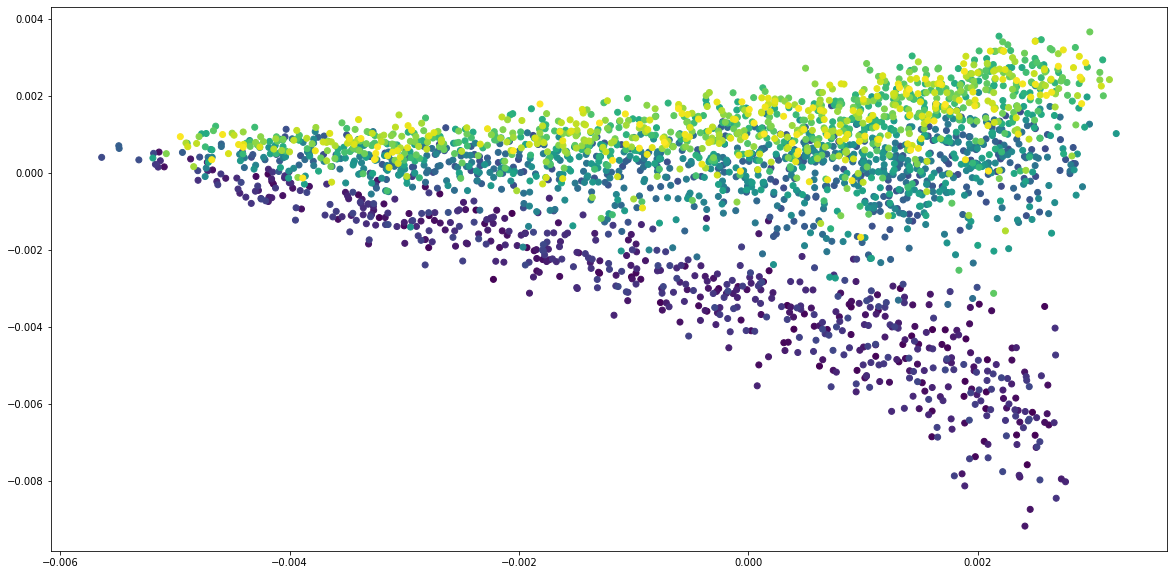

In [7]:
diffu = diff.diffusion_map(rna_pca, n_eign = 10, alpha = 15, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2], c=np.arange(rna.shape[0]))


In [8]:
# normalize both matrices for inner product loss
diff_sim_atac = torch.FloatTensor(diff_sim_atac).to(device)
diff_sim_rna = torch.FloatTensor(diff_sim_rna).to(device)
diff_sim_atac = diff_sim_atac / torch.norm(diff_sim_atac, p = 'fro')
diff_sim_rna = diff_sim_rna / torch.norm(diff_sim_rna, p = 'fro')

In [9]:
# pca calculated internally, no need to do pca before
DPT_atac = diff.DPT_similarity(atac)
DPT_rna = diff.DPT_similarity(rna)

# normalize both matrices for inner product loss
DPT_atac = torch.FloatTensor(DPT_atac).to(device)
DPT_rna = torch.FloatTensor(DPT_rna).to(device)
DPT_atac = DPT_atac / torch.norm(DPT_atac, p = 'fro')
DPT_rna = DPT_rna / torch.norm(DPT_rna, p = 'fro')

In [10]:
def dist_loss(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb, lamb_var, dist_loss_type = "cosine"):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = F.mse_loss(atac, recon_atac)

    # loss_variance = - lamb_var * (torch.sum((z[:,0] - torch.mean(z[:,0])) ** 2) + torch.sum((z[:,1] - torch.mean(z[:,1])) ** 2))

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [11]:
def train_ae(model, data_loader, lamb = 10, lamb_var = 0.1, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_var = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]
        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb = lamb, lamb_var = lamb_var, dist_loss_type= 'cosine')
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]

        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()
    
    scalar = data_loader.batch_size / len(dataset)
    return total_loss.item() * scalar, total_loss_recon_rna.item() * scalar, total_loss_recon_atac.item() * scalar, \
 total_loss_dist_rna.item() * scalar, total_loss_dist_atac.item() * scalar

In [12]:
def test(model, data_loader):
    for data in data_loader:
        recon_atac, recon_rna, z = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    r1 = F.mse_loss(torch.FloatTensor(atac).to(device), recon_atac).item()
    r2 = F.mse_loss(torch.FloatTensor(rna).to(device), recon_rna).item()
    return z, r1, r2

## AutoEncoder
Diffusion map as similarity matrix

In [ ]:
train_loader = DataLoader(dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(dataset, shuffle=True, batch_size=len(dataset))

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=32, latent_channels_rna=32, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 61):

    loss, l1, l2, l3, l4 = train_ae(model_ae, data_loader=train_loader, lamb = 100, similarity = "diffusion map")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

In [ ]:
z, l1, l2 = test(model_ae, data_loader = test_loader)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
print("atac recon loss: ", l1, "rna recon loss", l2)

DPT as similarity matrix

In [ ]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=16, latent_channels_rna=16, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 30):

    loss, l1, l2, l3, l4 = train_ae(model_ae, lamb = 100, similarity = "DPT")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

In [ ]:
z, l1, l2 = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
print("atac recon loss: ", l1, "rna recon loss", l2)